In [2]:
 %matplotlib inline
import cPickle as pkl
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mt
import matplotlib.cm as cm
import numpy.linalg as la
import scipy.ndimage as ndimage
 

def py_ang(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'    """
    cosang = np.dot(v1, v2)
    sinang = la.norm(np.cross(v1, v2))
    return np.arctan2(sinang, cosang)
def gradient_phase(f, *varargs, **kwargs):
    """
    Return the gradient of an N-dimensional array.

    The gradient is computed using second order accurate central differences
    in the interior and either first differences or second order accurate
    one-sides (forward or backwards) differences at the boundaries. The
    returned gradient hence has the same shape as the input array.

    Parameters
    ----------
    f : array_like
        An N-dimensional array containing samples of a scalar function.
    varargs : scalar or list of scalar, optional
        N scalars specifying the sample distances for each dimension,
        i.e. `dx`, `dy`, `dz`, ... Default distance: 1.
        single scalar specifies sample distance for all dimensions.
        if `axis` is given, the number of varargs must equal the number of axes.
    edge_order : {1, 2}, optional
        Gradient is calculated using N\ :sup:`th` order accurate differences
        at the boundaries. Default: 1.

        .. versionadded:: 1.9.1

    axis : None or int or tuple of ints, optional
        Gradient is calculated only along the given axis or axes
        The default (axis = None) is to calculate the gradient for all the axes of the input array.
        axis may be negative, in which case it counts from the last to the first axis.

        .. versionadded:: 1.11.0

    Returns
    -------
    gradient : list of ndarray
        Each element of `list` has the same shape as `f` giving the derivative
        of `f` with respect to each dimension.

    Examples
    --------
    >>> x = np.array([1, 2, 4, 7, 11, 16], dtype=np.float)
    >>> np.gradient(x)
    array([ 1. ,  1.5,  2.5,  3.5,  4.5,  5. ])
    >>> np.gradient(x, 2)
    array([ 0.5 ,  0.75,  1.25,  1.75,  2.25,  2.5 ])

    For two dimensional arrays, the return will be two arrays ordered by
    axis. In this example the first array stands for the gradient in
    rows and the second one in columns direction:

    >>> np.gradient(np.array([[1, 2, 6], [3, 4, 5]], dtype=np.float))
    [array([[ 2.,  2., -1.],
            [ 2.,  2., -1.]]), array([[ 1. ,  2.5,  4. ],
            [ 1. ,  1. ,  1. ]])]

    >>> x = np.array([0, 1, 2, 3, 4])
    >>> dx = np.gradient(x)
    >>> y = x**2
    >>> np.gradient(y, dx, edge_order=2)
    array([-0.,  2.,  4.,  6.,  8.])

    The axis keyword can be used to specify a subset of axes of which the gradient is calculated
    >>> np.gradient(np.array([[1, 2, 6], [3, 4, 5]], dtype=np.float), axis=0)
    array([[ 2.,  2., -1.],
           [ 2.,  2., -1.]])
    """
    f = np.asanyarray(f)
    N = len(f.shape)  # number of dimensions

    axes = kwargs.pop('axis', None)
    if axes is None:
        axes = tuple(range(N))
    # check axes to have correct type and no duplicate entries
    if isinstance(axes, int):
        axes = (axes,)
    if not isinstance(axes, tuple):
        raise TypeError("A tuple of integers or a single integer is required")

    # normalize axis values:
    axes = tuple(x + N if x < 0 else x for x in axes)
    if max(axes) >= N or min(axes) < 0:
        raise ValueError("'axis' entry is out of bounds")

    if len(set(axes)) != len(axes):
        raise ValueError("duplicate value in 'axis'")

    n = len(varargs)
    if n == 0:
        dx = [1.0]*N
    elif n == 1:
        dx = [varargs[0]]*N
    elif n == len(axes):
        dx = list(varargs)
    else:
        raise SyntaxError(
            "invalid number of arguments")

    edge_order = kwargs.pop('edge_order', 1)
    if kwargs:
        raise TypeError('"{}" are not valid keyword arguments.'.format(
                                                  '", "'.join(kwargs.keys())))
    if edge_order > 2:
        raise ValueError("'edge_order' greater than 2 not supported")

    # use central differences on interior and one-sided differences on the
    # endpoints. This preserves second order-accuracy over the full domain.

    outvals = []

    # create slice objects --- initially all are [:, :, ..., :]
    slice1 = [slice(None)]*N
    slice2 = [slice(None)]*N
    slice3 = [slice(None)]*N
    slice4 = [slice(None)]*N

    otype = f.dtype.char
    if otype not in ['f', 'd', 'F', 'D', 'm', 'M']:
        otype = 'd'

    # Difference of datetime64 elements results in timedelta64
    if otype == 'M':
        # Need to use the full dtype name because it contains unit information
        otype = f.dtype.name.replace('datetime', 'timedelta')
    elif otype == 'm':
        # Needs to keep the specific units, can't be a general unit
        otype = f.dtype

    # Convert datetime64 data into ints. Make dummy variable `y`
    # that is a view of ints if the data is datetime64, otherwise
    # just set y equal to the array `f`.
    if f.dtype.char in ["M", "m"]:
        y = f.view('int64')
    else:
        y = f

    for i, axis in enumerate(axes):

        if y.shape[axis] < 2:
            raise ValueError(
                "Shape of array too small to calculate a numerical gradient, "
                "at least two elements are required.")
        
        # Numerical differentiation: 1st order edges, 2nd order interior
        if y.shape[axis] == 2 or edge_order == 1:
            
            # Use first order differences for time data
            out = np.empty_like(y, dtype=otype)

            slice1[axis] = slice(1, -1)
            slice2[axis] = slice(2, None)
            slice3[axis] = slice(None, -2)
            # 1D equivalent -- out[1:-1] = (y[2:] - y[:-2])/2.0
            out[slice1] = (y[slice2] - y[slice3])
            out[slice1] = (out[slice1] + math.pi) % (2*math.pi) - math.pi
            out[slice1]=out[slice1]/2.0

            slice1[axis] = 0
            slice2[axis] = 1
            slice3[axis] = 0
            # 1D equivalent -- out[0] = (y[1] - y[0])
            out[slice1] = (y[slice2] - y[slice3])
            out[slice1] = (out[slice1] + math.pi) % (2*math.pi) - math.pi

            slice1[axis] = -1
            slice2[axis] = -1
            slice3[axis] = -2
            # 1D equivalent -- out[-1] = (y[-1] - y[-2])
            out[slice1] = (y[slice2] - y[slice3])
            out[slice1] = (out[slice1] + math.pi) % (2*math.pi) - math.pi

        # Numerical differentiation: 2st order edges, 2nd order interior
        else:
            # Use second order differences where possible
            out = np.empty_like(y, dtype=otype)

            slice1[axis] = slice(1, -1)
            slice2[axis] = slice(2, None)
            slice3[axis] = slice(None, -2)
            # 1D equivalent -- out[1:-1] = (y[2:] - y[:-2])/2.0
            out[slice1] = (y[slice2] - y[slice3])
            out[slice1] = (out[slice1] + math.pi) % (2*math.pi) - math.pi
            out[slice1] = out[slice1]/2

            slice1[axis] = 0
            slice2[axis] = 0
            slice3[axis] = 1
            slice4[axis] = 2
            # 1D equivalent -- out[0] = -(3*y[0] - 4*y[1] + y[2]) / 2.0
            out[slice1] = -(3.0*y[slice2] - 4.0*y[slice3] + y[slice4])
            out[slice1] = (out[slice1] + math.pi) % (2*math.pi) - math.pi
            out[slice1]=out[slice1]/2.0

            slice1[axis] = -1
            slice2[axis] = -1
            slice3[axis] = -2
            slice4[axis] = -3
            # 1D equivalent -- out[-1] = (3*y[-1] - 4*y[-2] + y[-3])
            out[slice1] = (3.0*y[slice2] - 4.0*y[slice3] + y[slice4])
            out[slice1] = (out[slice1] + math.pi) % (2*math.pi) - math.pi
            out[slice1]=out[slice1]/2.0

        # divide by step size
        out /= dx[i]
        outvals.append(out)

        # reset the slice object in this dimension to ":"
        slice1[axis] = slice(None)
        slice2[axis] = slice(None)
        slice3[axis] = slice(None)
        slice4[axis] = slice(None)

    if len(axes) == 1:
        return outvals[0]
    else:
        return outvals

In [181]:
# grab legends:
use_corrected_screen = True

legend_dir = '/home/juliana/Repositories/retinotopy-mapper/tests/simulation'

# MAKE LEGENDS:

winsize = [1920, 1200]
screen_size = [int(i*0.25) for i in winsize]
print screen_size

create_legend = 1

if create_legend:
    V_left_legend = np.zeros((screen_size[1], screen_size[0]))
    # First, set half the screen width (0 to 239 = to 0 to -pi)
    nspaces_start = np.linspace(0, -1*math.pi, screen_size[0]/2)
    for i in range(screen_size[1]):
        V_left_legend[i][0:screen_size[0]/2] = nspaces_start

    # Then, set right side of screen (240 to end = to pi to 0)
    nspaces_end = np.linspace(1*math.pi, 0, screen_size[0]/2)
    for i in range(screen_size[1]):
        V_left_legend[i][screen_size[0]/2:] = nspaces_end
        
else:
    legend_name = 'V-Left_legend.tif'
    V_left_legend = imread(os.path.join(legend_dir, legend_name))

    
if create_legend:
    V_right_legend = np.zeros((screen_size[1], screen_size[0]))
    # First, set half the screen width (0 to 239 = to 0 to -pi)
    nspaces_start = np.linspace(0, 1*math.pi, screen_size[0]/2)
    for i in range(screen_size[1]):
        V_right_legend[i][0:screen_size[0]/2] = nspaces_start
    # Then, set right side of screen (240 to end = to pi to 0)
    nspaces_end = np.linspace(-1*math.pi, 0, screen_size[0]/2)
    for i in range(screen_size[1]):
        V_right_legend[i][screen_size[0]/2:] = nspaces_end
        
else:
    legend_name = 'V-Right_legend.tif'
    V_right_legend = imread(os.path.join(legend_dir, legend_name))


ratio_factor = .5458049

if use_corrected_screen is True:
    screen_edge = math.pi - (math.pi*ratio_factor)
else:
    screen_edge = 0
    
if create_legend:        
    H_down_legend = np.zeros((screen_size[1], screen_size[0]))
    
    # First, set half the screen width (0 to 239 = to 0 to -pi)
    # If CORRECTING for true physical screen, start  after 0 (~1.43):
    nspaces_start = np.linspace(-1*screen_edge, -1*math.pi, screen_size[1]/2)
    
    for i in range(screen_size[0]):
        H_down_legend[0:screen_size[1]/2, i] = nspaces_start

    # Then, set right side of screen (240 to end = to pi to 0)
    nspaces_end = np.linspace(1*math.pi, screen_edge, screen_size[1]/2)
    for i in range(screen_size[0]):
        H_down_legend[screen_size[1]/2:, i] = nspaces_end
        
else:
    legend_name = 'H-Down_legend.tif'
    H_down_legend = imread(os.path.join(legend_dir, legend_name))


if create_legend:
    H_up_legend = np.zeros((screen_size[1], screen_size[0]))
    
    # First, set half the screen width (0 to 239 = to 0 to -pi)
    # If CORRECTING for true physical screen, start  after 0 (~1.43):
    nspaces_start = np.linspace(screen_edge, 1*math.pi, screen_size[1]/2)
    for i in range(screen_size[0]):
        H_up_legend[0:screen_size[1]/2, i] = nspaces_start

    # Then, set right side of screen (240 to end = to pi to 0)
    nspaces_end = np.linspace(-1*math.pi, -1*screen_edge, screen_size[1]/2)
    for i in range(screen_size[0]):
        H_up_legend[screen_size[1]/2:, i] = nspaces_end
else:
    legend_name = 'H-Up_legend.tif'
    H_up_legend = imread(os.path.join(legend_dir, legend_name))


[480, 300]


In [153]:
# outdir = '/nas/volume1/widefield/data/JR017W/20160817/JR017W_flash_bar_013Hz/structs'
# outdir = '/nas/volume1/widefield/data/JR016W/20160815/JR016W_bar_013Hz/structs'
outdir = '/nas/volume1/widefield/data/JR014W/20160819/JR014W_flash_bar_013Hz/structs'


# outdir = '/media/nas/volume1/widefield/data/JR016W/20160815/JR016W_bar_013Hz/structs'
# outdir = '/media/nas/volume1/widefield/data/JR014W/20160808/JR014W_bar_013Hz/structs'

# outdir = '/media/nas/volume1/widefield/data/JR006B/20160805/JR006B_bar_013Hz/structs'
# outdir = '/media/nas/volume1/widefield/data/JR006B/20160720/JR006W_30cyc_bar_013Hz/structs'


# outdir = '/media/nas/volume1/widefield/data/JR009/20150625/20150625_JR009_500um_0050Hz/structs'
# outdir = '/media/nas/volume1/widefield/data/JR009/20150625_block2/20150625_JR009_500um_0080Hz_blueLED/structs'

# outdir = '/media/nas/volume1/widefield/data/CE015/20160706/CE015_bar_013Hz/structs'
# outdir = '/media/nas/volume1/widefield/data/CE017/20160727/CE017_bar_013Hz/structs'

# outdir = '/media/nas/volume1/widefield/data/CE004/20160203/anesthetized_bar_0008/structs'

from skimage.measure import block_reduce
import math


exptdir = os.path.split(outdir)[0]
print exptdir

/nas/volume1/widefield/data/JR014W/20160819/JR014W_flash_bar_013Hz


In [154]:
rundir = os.path.split(outdir)[0]
sessiondir = os.path.split(rundir)[0]
reduceit=0

print sessiondir

/nas/volume1/widefield/data/JR014W/20160819


['16bitSurf (6)_surface.tif']
.tif


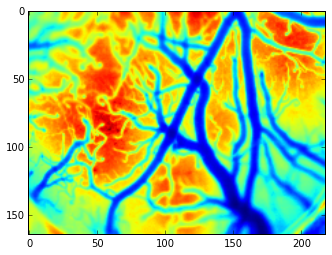

In [155]:
#################################################################################
# GET BLOOD VESSEL IMAGE:
#################################################################################
from libtiff import TIFF

# sessiondir = os.path.split(exptdir)[0]
# print sessiondir
folders = os.listdir(sessiondir)
# figpath = [f for f in folders if f == 'figures']
figpath = [f for f in folders if f == 'surface']

# for JR009:
# figpath = ['figures']
# sessiondir = '/media/nas/volume1/widefield/data/JR009/20150625'

if figpath:
    figdir = figpath[0]
    tmp_ims = os.listdir(os.path.join(sessiondir, figdir))
    surface_words = ['surface', 'GREEN', 'green', 'Surface', 'Surf']
    ims = [i for i in tmp_ims if any([word in i for word in surface_words])]
    ims = [i for i in ims if '_' in i]
    print ims
    impath = os.path.join(sessiondir, figdir, ims[0])
    # image = Image.open(impath) #.convert('L')
    # imarray = np.asarray(image)
    print os.path.splitext(impath)[1]
    if os.path.splitext(impath)[1] == '.tif':
        tiff = TIFF.open(impath, mode='r')
        surface = tiff.read_image().astype('float')
        tiff.close()
        plt.imshow(surface)
    else:
        import scipy.misc
        image = scipy.misc.imread(impath)
#         image = Image.open(impath) #.convert('L')
        surface = np.asarray(image)


else: # NO BLOOD VESSEL IMAGE...
    surface = np.zeros([200,300])

reduceit = 0
reduce_factor=(3, 3)
if reduceit:
    surface = block_reduce(surface, reduce_factor, func=np.mean)


plt.imshow(surface)

In [156]:
files = os.listdir(outdir)
files = [f for f in files if os.path.splitext(f)[1] == '.pkl']
# dstructs = [f for f in files if 'D_target_FFT' in f and str(reduce_factor) in f]
# if not dstructs:
#     dstructs = [f for f in files if 'D_' in f and str(reduce_factor) in f] # address older analysis formats

append='' #nas'
dstructs = [f for f in files if 'Target_fft' in f]
print dstructs

D = dict()
for f in dstructs:
    outfile = os.path.join(outdir, f)
    with open(outfile,'rb') as fp:
        D[f] = pkl.load(fp)


['Target_fft_Bottom_run1_(1, 1)_.pkl', 'Target_fft_Top_run1_(1, 1)_.pkl', 'Target_fft_Right_run1_(1, 1)_.pkl', 'Target_fft_Left_run1_(1, 1)_.pkl', 'Target_fft_blank_run0_(1, 1)_.pkl']


In [157]:
bottomkeys = [k for k in D.keys() if 'Bottom' in k or 'Up' in k]
topkeys = [k for k in D.keys() if 'Top' in k or 'Down' in k]

leftkeys = [k for k in D.keys() if 'Left' in k]
rightkeys = [k for k in D.keys() if 'Right' in k]

el_keys = [topkeys, bottomkeys]
az_keys = [leftkeys, rightkeys]

print "AZ keys: ", az_keys
print "EL keys: ", el_keys


AZ keys:  [['Target_fft_Left_run1_(1, 1)_.pkl'], ['Target_fft_Right_run1_(1, 1)_.pkl']]
EL keys:  [['Target_fft_Top_run1_(1, 1)_.pkl'], ['Target_fft_Bottom_run1_(1, 1)_.pkl']]


In [158]:

# ----------------------------------------------
# LEFT: 
# ----------------------------------------------
run_num = 1
reduce_factor = (1, 1)
append = '_.pkl'#'nas'
cond_type = 'Left'

run_conds = [cond_type, str(run_num)+'_', str(reduce_factor), append]

tmp_keys = [k for k in leftkeys if all([c in k for c in run_conds])] #[0]
if len(tmp_keys) > 1:
    print "More than 1 match found: "
    print tmp_keys
elif tmp_keys == []:
    print "No matches found from list: "
    print leftkeys
else:
    leftkey = tmp_keys[0]
    print "Curr key is: ", leftkey

leftmap = D[leftkey]['ft']


# ----------------------------------------------
# RIGHT: 
# ----------------------------------------------
run_num = 1 #2 #3
reduce_factor = (1, 1)
append = '_.pkl'#'nas'
cond_type = 'Right'

run_conds = [cond_type, str(run_num)+'_', str(reduce_factor), append]

tmp_keys = [k for k in rightkeys if all([c in k for c in run_conds])] #[0]
if len(tmp_keys) > 1:
    print "More than 1 match found: "
    print tmp_keys
elif tmp_keys == []:
    print "No matches found from list: "
    print rightkeys
else:
    rightkey = tmp_keys[0]
    print "Curr key is: ", rightkey

rightmap = D[rightkey]['ft']

Curr key is:  Target_fft_Left_run1_(1, 1)_.pkl
Curr key is:  Target_fft_Right_run1_(1, 1)_.pkl


In [159]:
# ----------------------------------------------
# TOP: 
# ----------------------------------------------

run_num = 1 #3
reduce_factor = (1, 1)
append = '' #'nas'
cond_type = 'Top'
# cond_type = 'Down'

run_conds = [cond_type, str(run_num)+'_', str(reduce_factor), append]

tmp_keys = [k for k in topkeys if all([c in k for c in run_conds])] #[0]
if len(tmp_keys) > 1:
    print "More than 1 match found: "
    print tmp_keys
elif tmp_keys == []:
    print "No matches found from list: "
    print topkeys
else:
    topkey = tmp_keys[0]
    print "Curr key is: ", topkey

topmap = D[topkey]['ft']



# ----------------------------------------------
# BOTTOM: 
# ----------------------------------------------

run_num = 1 #3
reduce_factor = (1, 1)
append = ''#'nas'
cond_type = 'Bottom'
# cond_type = 'Up'

run_conds = [cond_type, str(run_num)+'_', str(reduce_factor), append]

tmp_keys = [k for k in bottomkeys if all([c in k for c in run_conds])] #[0]
if len(tmp_keys) > 1:
    print "More than 1 match found: "
    print tmp_keys
elif tmp_keys == []:
    print "No matches found from list: "
    print bottomkeys
else:
    bottomkey = tmp_keys[0]
    print "Curr key is: ", bottomkey

bottommap = D[bottomkey]['ft']

Curr key is:  Target_fft_Top_run1_(1, 1)_.pkl
Curr key is:  Target_fft_Bottom_run1_(1, 1)_.pkl


<matplotlib.colorbar.Colorbar instance at 0x7f32ea730ef0>

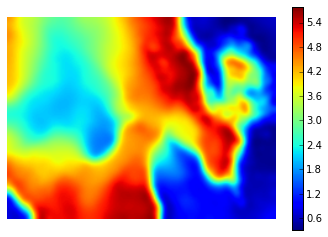

In [160]:
# file_dir = './JR017W_8_17_2016/'
# surffile = os.path.join(file_dir, '16bitSurf.tif')
# import scipy.misc

# surface = scipy.misc.imread(surffile)

#fn = 'Target_fft_Top_run1_(3, 3)_reduce.pkl'
# file_dir = './JR014W_8_8_2016/'
# import math
# from skimage.measure import block_reduce

# ## FOR NEW STUFF:
# leftkey = 'Target_fft_Left_run1_(1, 1)_.pkl'
# rightkey = 'Target_fft_Right_run1_(1, 1)_.pkl'
# topkey = 'Target_fft_Top_run1_(1, 1)_.pkl'
# bottomkey = 'Target_fft_Bottom_run1_(1, 1)_.pkl'

# leftkey = 'Target_fft_Left_run1_(3, 3)_reduce.pkl'
# rightkey = 'Target_fft_Right_run1_(3, 3)_reduce.pkl'
# topkey = 'Target_fft_Top_run1_(3, 3)_reduce.pkl'
# bottomkey = 'Target_fft_Bottom_run1_(3, 3)_reduce.pkl'



## FOR CE015 - 20160715:
# leftkey = 'Target_fft_Left_run0_(1, 1)_.pkl'
# rightkey = 'Target_fft_Right_run0_(1, 1)_.pkl'
# topkey = 'Target_fft_Top_run0_(1, 1)_.pkl'
# bottomkey = 'Target_fft_Bottom_run0_(1, 1)_.pkl'


## FOR old, INTRINSIC (JR009):
# leftkey = 'Target_fft_V-Left_0_(2, 2)_nas.pkl'
# rightkey = 'Target_fft_V-Right_0_(2, 2)_nas.pkl'
# topkey = 'Target_fft_H-Down_0_(2, 2)_nas.pkl'
# bottomkey = 'Target_fft_H-Up_00_(2, 2)_nas.pkl'


## FOR autofluorescence, JR009 (blueLED):
## outdir = '/media/nas/volume1/widefield/data/JR009/20150625_block2/20150625_JR009_500um_0080Hz_blueLED/structs'

# leftkey = 'Target_fft_V-Left_0_(2, 2)_.pkl'
# rightkey = 'Target_fft_V-Right_0_(2, 2)_.pkl'
# topkey = 'Target_fft_H-Down_0_(2, 2)_.pkl'
# bottomkey = 'Target_fft_H-Up_0_(2, 2)_.pkl'



## FOR OLD OLD stuff, CE014 - gcamp:

# leftkey = 'Target_fft_V-Left_1_(1, 1)_nas.pkl'
# rightkey = 'Target_fft_V-Right_1_(1, 1)_nas.pkl'
# topkey = 'Target_fft_H-Down_1_(1, 1)_nas.pkl'
# bottomkey = 'Target_fft_H-Up_0_(1, 1)_nas.pkl'


sigma_val = (3,3)

D = dict()
condkeys = [leftkey, rightkey, topkey, bottomkey]
for condkey in condkeys:
    outfile = os.path.join(outdir, condkey)
    with open(outfile,'rb') as fp:
        D[condkey] = pkl.load(fp)

        
Hmap = D[bottomkey]['phase_map']
# Hmap = D[topkey]['phase_map']

#smooth map
Hmap[Hmap<0]=2*math.pi+Hmap[Hmap<0]

Hmap = ndimage.gaussian_filter(Hmap, sigma=sigma_val, order=0)
plt.imshow(Hmap,cmap = 'jet')
plt.xticks([]), plt.yticks([]);
plt.axis('off')
plt.colorbar()

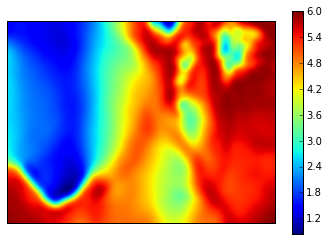

In [161]:
# file_dir='./JR017W_8_17_2016/'
# #fn = 'Target_fft_Right_run1_(3, 3)_reduce.pkl'

# # file_dir = './JR014W_8_8_2016/'
# fn = 'Target_fft_Right_run2_(1, 1)_.pkl'

# outfile = os.path.join(file_dir, fn)
# with open(outfile,'rb') as fp:
# 	D = pkl.load(fp)

Vmap = D[leftkey]['phase_map']
# Vmap = D[rightkey]['phase_map']


#smooth map
Vmap[Vmap<0]=2*math.pi+Vmap[Vmap<0]
Vmap = ndimage.gaussian_filter(Vmap, sigma=sigma_val, order=0)

plt.imshow(Vmap,cmap = 'jet')
plt.xticks([]), plt.yticks([]);
plt.colorbar();

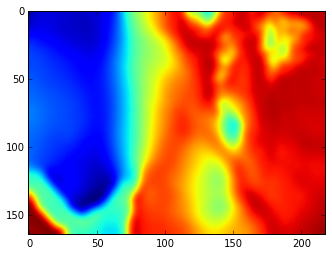

In [288]:
# Get average AZ:

import copy 

left_phase = np.angle(leftmap) #D[leftkey]['phase_map']
right_phase = np.angle(rightmap.conjugate()) #D[rightkey]['phase_map']

# left_phase = np.angle(leftmap.conjugate()) #D[leftkey]['phase_map']
# right_phase = np.angle(rightmap) #D[rightkey]['phase_map']


vmin_val = -1*math.pi
vmax_val = 1*math.pi

# Do the thing to deal with averaging across -pi and pi:
# Vmap[Vmap<0]=2*math.pi+Vmap[Vmap<0]
left_phase[left_phase<0] += 2*math.pi
right_phase[right_phase<0] += 2*math.pi

V_left_legend_shifted = copy.deepcopy(V_left_legend)
V_left_legend_shifted[V_left_legend_shifted<0] += 2*math.pi

V_right_legend_shifted = copy.deepcopy(V_right_legend)
V_right_legend_shifted[V_right_legend_shifted<0] += 2*math.pi


smooth = True
sigma_val = (3,3)
if smooth is True:
    left_phase = ndimage.gaussian_filter(left_phase, sigma=sigma_val, order=0)
    right_phase = ndimage.gaussian_filter(right_phase, sigma=sigma_val, order=0)
    
    
    
vmin_val = 0
vmax_val = 2*math.pi

az_avg = (left_phase + right_phase) / 2.
# az_avg = left_phase

plt.imshow(az_avg)

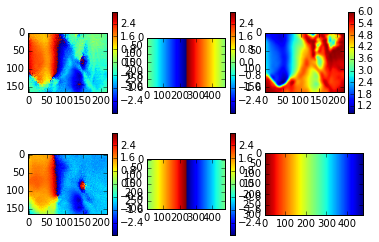

In [289]:
plt.subplot(2,3,1)
plt.imshow(np.angle(leftmap))
plt.colorbar()

plt.subplot(2,3,2)
plt.imshow(V_left_legend)
plt.colorbar()

plt.subplot(2,3,3)
plt.imshow(left_phase)
plt.colorbar()

plt.subplot(2,3,4)
plt.imshow(np.angle(rightmap.conjugate()))
plt.colorbar()

plt.subplot(2,3,5)
plt.imshow(V_right_legend)
plt.colorbar()

plt.subplot(2,3,6)
plt.imshow(V_left_legend_shifted)

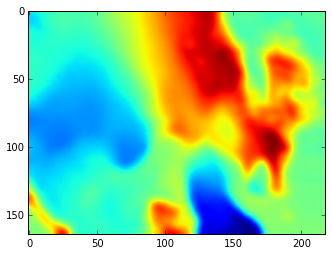

In [292]:
# Get average EL:

# top_phase = np.angle(topmap) #D[leftkey]['phase_map']
# bottom_phase = np.angle(bottommap.conjugate()) #D[rightkey]['phase_map']
# bottom_phase = np.angle(bottommap) #D[leftkey]['phase_map']

# top_phase = np.angle(topmap) #D[rightkey]['phase_map']
# bottom_phase = np.angle(bottommap.conjugate())


top_phase = np.angle(topmap.conjugate()) #D[rightkey]['phase_map']
bottom_phase = np.angle(bottommap)

# CHECK THIS:
# left - bottom
# right - top.
# otherwise, have to flip sign of O.

vmin_val = -1*math.pi
vmax_val = 1*math.pi

# Do the thing to deal with averaging across -pi and pi:
# Vmap[Vmap<0]=2*math.pi+Vmap[Vmap<0]
top_phase[top_phase<0] += 2*math.pi
bottom_phase[bottom_phase<0] += 2*math.pi

H_down_legend_shifted = copy.deepcopy(H_down_legend) # NEED to use the non-conjugated legend
H_down_legend_shifted[H_down_legend_shifted<0] += 2*math.pi

H_up_legend_shifted = copy.deepcopy(H_up_legend)
H_up_legend_shifted[H_up_legend_shifted<0] += 2*math.pi

vmin_val = 0
vmax_val = 2*math.pi


smooth = True
sigma_val = (3,3)
if smooth is True:
    top_phase = ndimage.gaussian_filter(top_phase, sigma=sigma_val, order=0)
    bottom_phase = ndimage.gaussian_filter(bottom_phase, sigma=sigma_val, order=0)
    
    
# el_avg = (top_phase + bottom_phase) / 2.
el_avg = (top_phase + bottom_phase) / 2. #top_phase

plt.imshow(el_avg)

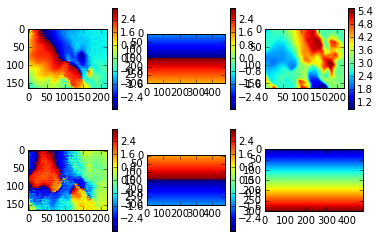

In [293]:
plt.subplot(2,3,1)
plt.imshow(np.angle(topmap.conjugate()))
plt.colorbar()

plt.subplot(2,3,2)
plt.imshow(H_down_legend)
plt.colorbar()

plt.subplot(2,3,3)
plt.imshow(el_avg)
plt.colorbar()

plt.subplot(2,3,4)
plt.imshow(np.angle(bottommap))
plt.colorbar()

plt.subplot(2,3,5)
plt.imshow(H_up_legend)
plt.colorbar()

plt.subplot(2,3,6)
plt.imshow(H_up_legend_shifted)


In [304]:

# Hmap = np.angle(topmap) # az_avg
# Vmap = np.angle(rightmap) #el_avg

# Hmap[Hmap<0]=2*math.pi+Hmap[Hmap<0]
# Vmap[Vmap<0]=2*math.pi+Vmap[Vmap<0]

Hmap = az_avg
Vmap = el_avg

smooth = True
if smooth is True:
    Hmap = ndimage.gaussian_filter(Hmap, sigma=sigma_val, order=0)
    Vmap = ndimage.gaussian_filter(Vmap, sigma=sigma_val, order=0)

[Hgy,Hgx]=np.array(gradient_phase(Hmap))

# Hgy =(Hgy + math.pi) % (2*math.pi) - math.pi
# Hgx =(Hgx + math.pi) % (2*math.pi) - math.pi

[Vgy,Vgx]=np.array(gradient_phase(Vmap))

# Vgy =(Vgy + math.pi) % (2*math.pi) - math.pi
# Vgx =(Vgx + math.pi) % (2*math.pi) - math.pi

#[size1,size2]=np.shape(Hgx)
#[size1,size2,size3]=np.shape(Hgrad)
# print(type(Hgrad))
# print(np.shape(Hgrad))
# x1=Hgrad[0,0,0]
# x2=Hgrad[1,0,0]
# print(x1)
# d=py_ang(x1,x2)
# print(d)
# plt.imshow(Hgx,cmap='jet');
# plt.xticks([]), plt.yticks([]);
# plt.colorbar();

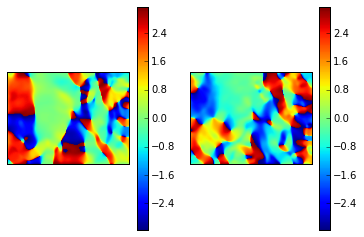

In [305]:
Hgdir=np.arctan2(Hgy,Hgx) # gradient direction
Vgdir=np.arctan2(Vgy,Vgx)
# Hgdir[Hgdir<0]=2*math.pi+Hgdir[Hgdir<0]
# Vgdir[Vgdir<0]=2*math.pi+Vgdir[Vgdir<0]
plt.subplot(121)
plt.imshow(Hgdir,cmap='jet');
plt.xticks([]), plt.yticks([]);
plt.colorbar();
plt.subplot(122)
plt.imshow(Vgdir,cmap='jet');
plt.xticks([]), plt.yticks([]);
plt.colorbar();

<matplotlib.colorbar.Colorbar instance at 0x7f32d6b35290>

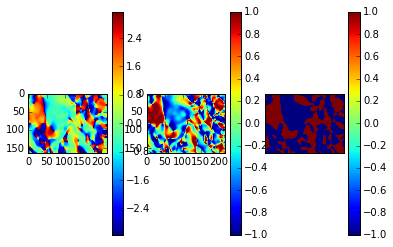

In [306]:

D = Vgdir-Hgdir
D = (D + math.pi) % (2*math.pi) - math.pi

# O=-1*np.sin(D)
O=np.sin(D)
S=np.sign(O)


plt.subplot(131)
plt.imshow(D,cmap='jet');
#plt.xticks([]), plt.yticks([]);
plt.colorbar()

plt.subplot(132)
plt.imshow(O,cmap='jet');
#plt.xticks([]), plt.yticks([]);
plt.colorbar()

plt.subplot(133)
plt.imshow(S,cmap='jet');
plt.xticks([]), plt.yticks([]);
plt.colorbar()
#plt.savefig('signmap.png')
# print(D[50,100])
# print(O[50,100])
# print(S[50,100])

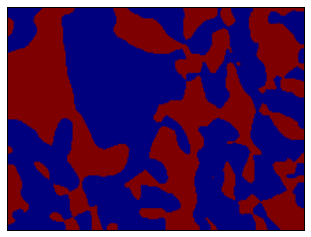

In [307]:

plt.imshow(S,cmap='jet');
plt.xticks([]), plt.yticks([]);

#plt.savefig('signmap.png')

# RED = MIRRORED (+1)
# BLUE = NON-MIRRORED (-1)

# Regions having a positive field sign (red) represent nonmirror image transformations of the visual field. 
# A negative field sign (blue) indicates a mirror image representation. 
# Regions with values close to zero lack defined topographic structure. 
# Transitions in field sign between positive and negative values correspond to reversals 
# in the organization of the visual map gradients. 

(-0.5, 217.5, 163.5, -0.5)

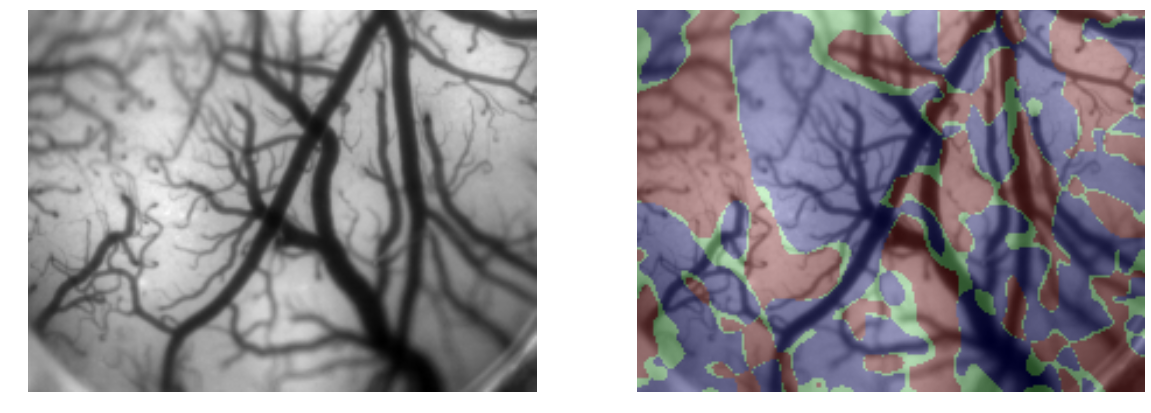

In [308]:
O_sigma=np.std(O)

S_thresh=np.zeros(np.shape(O))
std_thresh = 0.2
S_thresh[O>(O_sigma*std_thresh)]=1
S_thresh[O<-(O_sigma*std_thresh)]=-1

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(surface, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(surface, cmap='gray')
plt.imshow(S_thresh,cmap='jet', alpha=0.3);
plt.axis('off')
# plt.colorbar();

#plt.savefig('signmap.png')

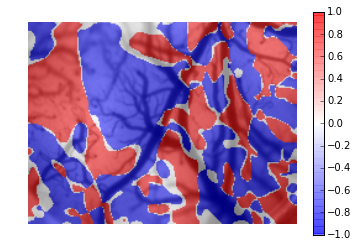

In [309]:
plt.imshow(surface, cmap='gray')
plt.imshow(S_thresh,cmap='bwr', alpha=0.5);
plt.axis('off')
plt.colorbar();

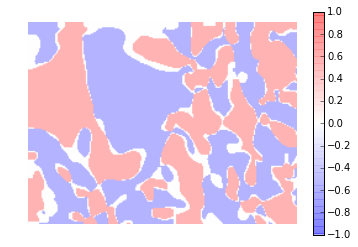

In [302]:


from scipy import ndimage
# im2 = ndimage.grey_dilation(S_thresh)

import cv2
kernel = np.ones((2,2),np.uint8)

opening = cv2.morphologyEx(S_thresh, cv2.MORPH_OPEN, kernel)

closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
opening2 = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel)

dilation = cv2.dilate(opening2,kernel,iterations = 1)


plt.imshow(dilation,cmap='bwr', alpha=0.3);
plt.axis('off')
plt.colorbar();

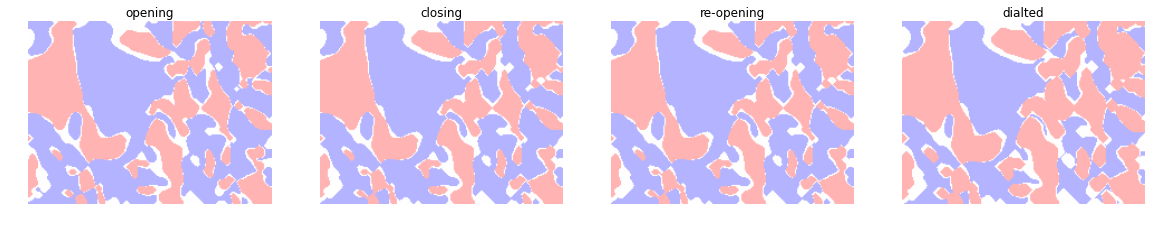

In [303]:
from skimage.morphology import erosion, dilation, opening, closing, white_tophat
from skimage.morphology import black_tophat, skeletonize, convex_hull_image

from skimage.morphology import disk

selem = disk(2)

plt.figure(figsize=(20,10))

# OPEN:
plt.subplot(1,4,1)
opened = opening(S_thresh, selem)
plt.imshow(opened,cmap='bwr', alpha=0.3);
plt.axis('off')
plt.title('opening')

# CLOSE:
plt.subplot(1,4,2)
# closed = closing(opened, selem)
closed = closing(opened, selem)
plt.imshow(closed,cmap='bwr', alpha=0.3);
plt.axis('off')
plt.title('closing')

# OPEN2:
plt.subplot(1,4,3)
opened2 = closing(closed, selem)
plt.imshow(opened2,cmap='bwr', alpha=0.3);
plt.axis('off')
plt.title('re-opening')

# DILATE:
plt.subplot(1,4,4)
dilated = dilation(opened2, selem)
# skel = skeletonize(dilated)
plt.imshow(dilated,cmap='bwr', alpha=0.3);
plt.axis('off')
plt.title('dialted')
# plt.colorbar();